In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsvd import NSVD
from norwai_county import NSVDModel
from norwai_county_test import CNN, ConvModule
import geopandas as gpd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


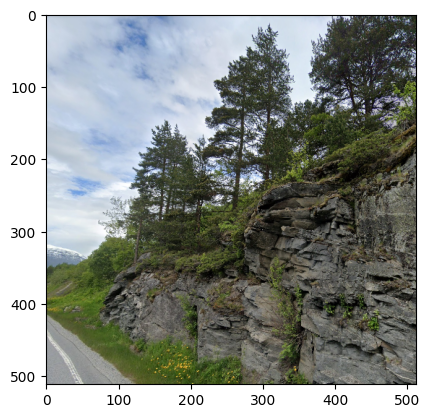

In [21]:
test_images = [{'file':'dskaldksalkdsa', 'loc':[62.31631851,8.093368]}]
test_im = np.random.choice(test_images, 1)[0]

from PIL import Image

im = Image.open('./data/test_images/{}.png'.format(test_im['file'])).convert('RGB')
w, h = im.size
left = int((w - 512)/2)
top = int((h - 512)/2)
right = int((w + 512)/2)
bottom = int((h + 512)/2)

im = im.crop((left, top, right, bottom)).resize((512, 512))
im_data = torch.tensor(np.asarray(im).transpose(2, 0, 1))

plt.imshow(im_data.int().numpy().transpose(1, 2, 0))
plt.show()

In [22]:
print(im_data)

tensor([[[183, 182, 181,  ...,  27,  21,  39],
         [185, 185, 184,  ...,  37,  44,  34],
         [188, 188, 188,  ...,  66,  35,  29],
         ...,
         [153, 145, 148,  ...,  90,  96,  95],
         [140, 147, 152,  ...,  82,  93, 103],
         [153, 150, 139,  ...,  81,  81,  93]],

        [[194, 193, 192,  ...,  36,  35,  41],
         [196, 196, 195,  ...,  52,  59,  37],
         [200, 200, 200,  ...,  75,  47,  33],
         ...,
         [156, 148, 151,  ...,  91,  97,  96],
         [143, 150, 155,  ...,  87,  98, 105],
         [156, 153, 142,  ...,  82,  83,  94]],

        [[207, 206, 205,  ...,  24,  21,  31],
         [210, 210, 208,  ...,  37,  45,  26],
         [213, 213, 213,  ...,  62,  33,  22],
         ...,
         [161, 153, 156,  ...,  86,  91,  90],
         [148, 155, 160,  ...,  80,  92, 100],
         [161, 158, 147,  ...,  77,  78,  89]]], dtype=torch.uint8)


In [23]:
mean = 135.4867 # fix this
std = 64.0806 # fix this
im_data = im_data.to(device)
im_data = (im_data - mean) / std

model = torch.load('./data/runns/15Nov221404//model_classification')
model.to(device)

guessed_county = None
with torch.no_grad():
  #y = model(im_data.unsqueeze(0)).flatten()
  y = model(im_data.unsqueeze(0)).flatten()
  
  #guessed_county = y.argmax().item()
  #print(guessed_county)

  print(torch.exp(y))
  guessed_county = torch.argmax(torch.exp(y)).item()


tensor([0.2068, 3.5781, 0.1351, 0.9728, 0.6415, 0.0348, 3.2048, 1.2770, 0.4104,
        0.5912], device='cuda:0')


tensor([-2.7660, -4.7697, -0.9924, -2.6751, -4.7380, -4.6915, -3.9974, -1.0149,
        -3.5734, -3.2383, -3.7712], device='cuda:0')

        tensor([0.0229, 0.0040, 0.1579, 0.0185, 0.0032, 0.0243, 0.0349, 0.4960, 0.0541,
        0.1400, 0.0442], device='cuda:0')

In [24]:
df = pd.read_json("./data/norge.geojson")
fylker = df["administrative_enheter.fylke"]["features"]

In [25]:
import folium

real_loc = test_im['loc']
FYLKESNUMMER_INDEX = [42, 54, 15, 38, 50, 11, 34, 30, 18, 46]

fylke = None

for f in fylker:
    if int(f["properties"]["fylkesnummer"]) == FYLKESNUMMER_INDEX[guessed_county]:
        print("found")
        fylke = f
        break


found


In [26]:
print(fylke["properties"]["fylkesnummer"])

54


In [27]:
gdf = gpd.GeoDataFrame.from_features([fylke])

In [28]:
#gdf = gpd.GeoDataFrame.from_features(fylker)
#sim_geo = gpd.GeoSeries(fylke['geometry']).simplify(tolerance=0.001)
#geo_j = sim_geo.to_json()
gdf = gdf.set_crs(epsg=25833)
gdf = gdf.to_crs(epsg=4326)
geo_j = folium.GeoJson(data=gdf["geometry"][0],
    style_function=lambda x: {'fillColor': 'orange'})


m = folium.Map((64.9701, 13.509217), zoom_start=4)


geo_j.add_to(m)
folium.CircleMarker(location=(real_loc[0], real_loc[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
m